In [1]:
!pip install datasets
!pip install dataset
!pip install transformers
!pip install sacrebleu
!pip install SentencePiece
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.20
    Uninstalling SQLAlchemy-2.0.20:
      Successfully uninstalled SQLAlchemy-2.0.20
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-s

In [2]:
import pandas as pd
import numpy as np
import re
import string
import warnings
from collections import Counter
from unicodedata import normalize
from scipy.stats import pearsonr

import tensorflow as tf
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, Embedding, RepeatVector, TimeDistributed, Bidirectional, Dropout, Input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences, to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.layers import Attention, Concatenate
from transformers import MT5ForConditionalGeneration, T5Tokenizer, TrainingArguments, Trainer, MBartForConditionalGeneration, MBartTokenizer, MarianTokenizer, MarianMTModel
from torch.utils.data import Dataset

import nltk
from nltk.util import ngrams
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from bidi.algorithm import get_display
import arabic_reshaper

import sacrebleu
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import Markdown, display


In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
def clean_english_text(text):
    text = text.lower()
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(f'[{string.punctuation}]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

def clean_arabic_text(text):
    text = re.sub("[ًٌٍَُِّْٰٖٓٗ٘]", "", text)
    text = re.sub("ـ", "", text)
    text = re.sub("[أإآ]", "ا", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("[ئؤ]", "ء", text)
    text = re.sub("گ", "ك", text)
    text = re.sub(f'[{string.punctuation}]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\sا-ي]', '', text)
    return text

df = pd.read_csv("ara_eng.txt", delimiter="\t", names=["english", "arabic"])
df.dropna(inplace=True)

english_sentences = df['english'].tolist()
arabic_sentences = df['arabic'].tolist()

df['arabic_length'] = df['arabic'].apply(lambda x: len(x.split()))
df['english_length'] = df['english'].apply(lambda x: len(x.split()))

english_sentences_clean = [clean_english_text(sentence) for sentence in english_sentences]
arabic_sentences_clean = [clean_arabic_text(sentence) for sentence in arabic_sentences]

zero_length_english_indices = [i for i, sentence in enumerate(english_sentences_clean) if len(sentence.split()) == 0]
zero_length_arabic_indices = [i for i, sentence in enumerate(arabic_sentences_clean) if len(sentence.split()) == 0]

indices_to_remove = set(zero_length_english_indices + zero_length_arabic_indices)

english_sentences_clean = ["<bos> " + sentence + " <eos>"for i, sentence in enumerate(english_sentences_clean) if i not in indices_to_remove]
arabic_sentences_clean =  ["<bos> " + sentence + " <eos>"for i, sentence in enumerate(arabic_sentences_clean) if i not in indices_to_remove]


In [10]:
portion_length = int(0.4 * len(arabic_sentences_clean))
arabic_sentences_clean = arabic_sentences_clean[:portion_length]
english_sentences_clean = english_sentences_clean[:portion_length]

test_proportion = 0.1
train_test_threshold = int((1 - test_proportion) * len(arabic_sentences_clean))

train_ar, test_ar = arabic_sentences_clean[:train_test_threshold], arabic_sentences_clean[train_test_threshold:]
train_en, test_en = english_sentences_clean[:train_test_threshold], english_sentences_clean[train_test_threshold:]

def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def max_len(lines):
    return max(len(line.split()) for line in lines)

def encode_sequences(tokenizer, length, lines):
    X = tokenizer.texts_to_sequences(lines)
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

def encode_output(sequences, vocab_size):
    ylist = [to_categorical(sequence, num_classes=vocab_size) for sequence in sequences]
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

tar_tokenizer = create_tokenizer(english_sentences_clean)
tar_vocab_size = len(tar_tokenizer.word_index) + 1
tar_length = max_len(english_sentences_clean)

src_tokenizer = create_tokenizer(arabic_sentences_clean)
src_vocab_size = len(src_tokenizer.word_index) + 1
src_length = max_len(arabic_sentences_clean)

trainX = encode_sequences(src_tokenizer, src_length, train_ar)
trainY = encode_sequences(tar_tokenizer, tar_length, train_en)
trainY = encode_output(trainY, tar_vocab_size)

testX = encode_sequences(src_tokenizer, src_length, test_ar)
testY = encode_sequences(tar_tokenizer, tar_length, test_en)
testY = encode_output(testY, tar_vocab_size)

# **Descriptive Analytics**

## **Data Exploration:**

In [ ]:
english_sentence_lengths = [len(sentence.split()) for sentence in english_sentences_clean]
arabic_sentence_lengths = [len(sentence.split()) for sentence in arabic_sentences_clean]

english_vocab_size = len(tokenizer_eng.word_index) + 1
arabic_vocab_size = len(tokenizer_ar.word_index) + 1

avg_word_length_eng = np.mean([len(word) for sentence in english_sentences_clean for word in sentence.split()])
avg_word_length_ar = np.mean([len(word) for sentence in arabic_sentences_clean for word in sentence.split()])

avg_words_per_sentence_eng = np.mean([len(sentence.split()) for sentence in english_sentences_clean])
avg_words_per_sentence_ar = np.mean([len(sentence.split()) for sentence in arabic_sentences_clean])

print(f"English: \n Average word length: {avg_word_length_eng} \n Average number of words per sentence: {avg_words_per_sentence_eng} \n Max sentence length: {max(english_sentence_lengths)} \n Min sentence length: {min(english_sentence_lengths)} \n Average sentence length: {sum(english_sentence_lengths)/len(english_sentence_lengths)} \n Vocabulary Size: {english_vocab_size}")
print("\n")
print(f"Arabic: \n Average word length: {avg_word_length_ar} \n Average number of words per sentence: {avg_words_per_sentence_ar} \n Max sentence length: {max(arabic_sentence_lengths)} \n Min sentence length: {min(arabic_sentence_lengths)} \n Average sentence length: {sum(arabic_sentence_lengths)/len(arabic_sentence_lengths)} \n Vocabulary Size: {arabic_vocab_size}")

English: 
 Average word length: 4.7768838806086995 
 Average number of words per sentence: 17.62807971749807 
 Max sentence length: 225 
 Min sentence length: 1 
 Average sentence length: 17.62807971749807 
 Vocabulary Size: 25998


Arabic: 
 Average word length: 4.793183536782975 
 Average number of words per sentence: 15.029427284166092 
 Max sentence length: 225 
 Min sentence length: 1 
 Average sentence length: 15.029427284166092 
 Vocabulary Size: 52737


In [ ]:
correlation, _ = pearsonr(english_sentence_lengths, arabic_sentence_lengths)
print('Pearson correlation (correlation between english and arabic sentence lengths): %.3f' % correlation)

Pearson correlation: 0.978


Findings based on the above statistics:

* The vocabulary size of Arabic is about twice as much as English. This isn't surprising considering Arabic is a morphologically rich language and tends to have more unique words due to variations in word forms.

* English sentences tend to be longer, which indicates that English translations might use more words to express the same concepts as in Arabic, or the English dataset could contain more detailed or elaborate sentences.

* The average word length for both English and Arabic sentences is quite close. This similarity might indicate that, in general, the complexity in terms of individual word length is comparable between the two languages in your dataset.


## **Word Frequency Analysis:**

In [ ]:
stop_words_eng = set(stopwords.words('english'))
stop_words_ar = set(nltk.corpus.stopwords.words("arabic"))

english_word_lengths = [len(word) for word in nltk.word_tokenize(' '.join(english_sentences_clean)) if word.lower() not in stop_words_eng]
arabic_word_lengths = [len(word) for word in nltk.word_tokenize(' '.join(arabic_sentences_clean)) if word not in stop_words_ar]

english_word_length_freq = FreqDist(english_word_lengths)
arabic_word_length_freq = FreqDist(arabic_word_lengths)

english_most_common_word_lengths = english_word_length_freq.most_common(10)
arabic_most_common_word_lengths = arabic_word_length_freq.most_common(10)

num_unique_words_eng = len(set(word for sentence in english_sentences_clean for word in sentence.split()))
num_unique_words_ar = len(set(word for sentence in arabic_sentences_clean for word in sentence.split()))

english_word_freq = FreqDist(nltk.word_tokenize(' '.join(english_sentences_clean)))
arabic_word_freq = FreqDist(nltk.word_tokenize(' '.join(arabic_sentences_clean)))

english_rare_words = [word for word, count in english_word_freq.items() if count == 1]
arabic_rare_words = [word for word, count in arabic_word_freq.items() if count == 1]

english_sample_rare_words = english_rare_words[:10]
arabic_sample_rare_words = arabic_rare_words[:10]

freq_dist_eng_no_stopwords = FreqDist(word for sentence in english_sentences_clean for word in sentence.split() if word.lower() not in stop_words_eng)
freq_dist_ar_no_stopwords = FreqDist(word for sentence in arabic_sentences_clean for word in sentence.split() if word not in stop_words_ar)

english_most_common_no_stopwords = freq_dist_eng_no_stopwords.most_common(10)
arabic_most_common_no_stopwords = freq_dist_ar_no_stopwords.most_common(10)

freq_dist_eng = FreqDist(word for sentence in english_sentences_clean for word in sentence.split())
freq_dist_ar = FreqDist(word for sentence in arabic_sentences_clean for word in sentence.split())

num_stop_words_eng = len([word for sentence in english_sentences_clean for word in sentence.split() if word in stop_words_eng])
english_stop_word_counts = {word: freq_dist_eng[word] for word in stop_words_eng if word in freq_dist_eng}
most_common_stop_words_eng = sorted(english_stop_word_counts.items(), key=lambda x: x[1], reverse=True)[:10]

num_stop_words_ar = len([word for sentence in arabic_sentences_clean for word in sentence.split() if word in stop_words_ar])
arabic_stop_word_counts = {word: freq_dist_ar[word] for word in stop_words_ar if word in freq_dist_ar}
most_common_stop_words_ar = sorted(arabic_stop_word_counts.items(), key=lambda x: x[1], reverse=True)[:10]

def extract_ngrams(sentences, n):
    ngram_list = []
    for sentence in sentences:
        tokens = sentence.split()
        ngram_list.extend(list(nltk.ngrams(tokens, n)))
    return ngram_list

english_bigrams = extract_ngrams(english_sentences_clean, 2)
english_trigrams = extract_ngrams(english_sentences_clean, 3)

arabic_bigrams = extract_ngrams(arabic_sentences_clean, 2)
arabic_trigrams = extract_ngrams(arabic_sentences_clean, 3)

english_bigram_freq = nltk.FreqDist(english_bigrams)
english_trigram_freq = nltk.FreqDist(english_trigrams)

arabic_bigram_freq = nltk.FreqDist(arabic_bigrams)
arabic_trigram_freq = nltk.FreqDist(arabic_trigrams)

print(f"English: \n Word length distribution: {english_most_common_word_lengths} \n Number of unique words: {num_unique_words_eng} \n Number of rare words: {len(english_rare_words)} \n Number of stop words: {num_stop_words_eng} \n Most common stop words: {most_common_stop_words_eng} \n Most common unique words(unigrams): {english_most_common_no_stopwords} \n Sample of rare words: {english_sample_rare_words} \n Most common bigrams: {english_bigram_freq.most_common(10)} \n Most common trigrams: {english_trigram_freq.most_common(10)}")
print("\n")
print(f"Arabic: \n Word length distribution: {arabic_most_common_word_lengths} \n Number of unique words: {num_unique_words_ar} \n Number of rare words: {len(arabic_rare_words)} \n Number of stop words: {num_stop_words_ar} \n Most common stop words: {most_common_stop_words_ar} \n Most common unique words(unigrams): {arabic_most_common_no_stopwords} \n Sample of rare words

English: 
 Word length distribution: [(6, 43059), (5, 41125), (4, 39546), (7, 35365), (8, 26764), (9, 17854), (3, 16163), (10, 11574), (11, 6310), (2, 5599)] 
 Number of unique words: 25997 
 Number of rare words: 11842 
 Number of stop words: 184508 
 Most common stop words: [('the', 23882), ('of', 11606), ('to', 11292), ('in', 9824), ('and', 9761), ('a', 9324), ('is', 5216), ('on', 4171), ('i', 4046), ('for', 3963)] 
 Most common unique words(unigrams): [('global', 2708), ('voices', 2691), ('people', 1035), ('one', 1012), ('tom', 971), ('like', 776), ('also', 761), ('new', 726), ('media', 721), ('world', 719)] 
 Sample of rare words: ['waved', 'unsure', 'yawned', 'discreet', 'merciful', 'windy', 'tvs', 'gawking', 'observant', 'lasagna'] 
 Most common bigrams: [(('of', 'the'), 2775), (('global', 'voices'), 2532), (('in', 'the'), 2033), (('to', 'the'), 1109), (('on', 'the'), 1030), (('for', 'the'), 632), (('is', 'a'), 578), (('and', 'the'), 559), (('from', 'the'), 544), (('in', 'a'), 5

Findings based on the above statistics:


* There is a minor shift in the peak word lengths in Arabic when compared to English.

* The dataset appears to have recurring themes or expressions like 'global voices', 'used with permission', and 'special coverage'. These can provide insights into the type of content (perhaps news articles or blog posts) and their sourcing and categorization.

* There seems to be an overlap in the core themes and topics between the English and Arabic datasets. Terms related to global voices, media, and the internet consistently appear in both, implying that the dataset might be from a source discussing global events, trends, or news.

* The vast difference in vocabulary size between the two languages could pose challenges in translation. Given that Arabic has a more extensive vocabulary in this dataset, ensuring a comprehensive translation without loss of nuanced meanings can be tricky.

* The average word length for both English and Arabic sentences is quite close. This similarity might indicate that, in general, the complexity in terms of individual word length is comparable between the two languages in your dataset.


## **Visualizations:**

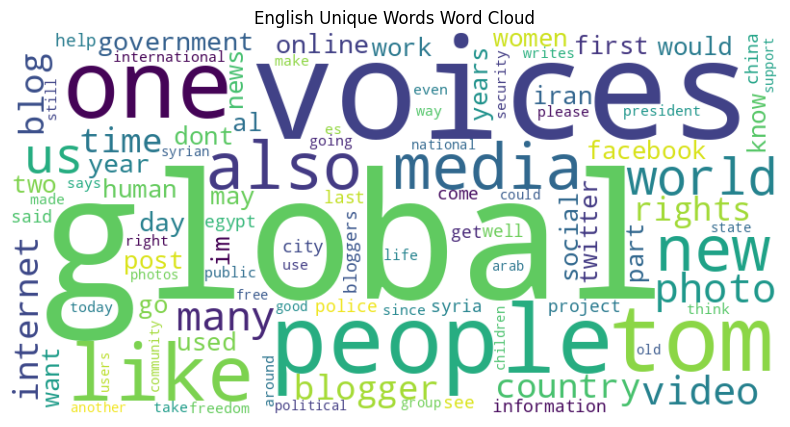

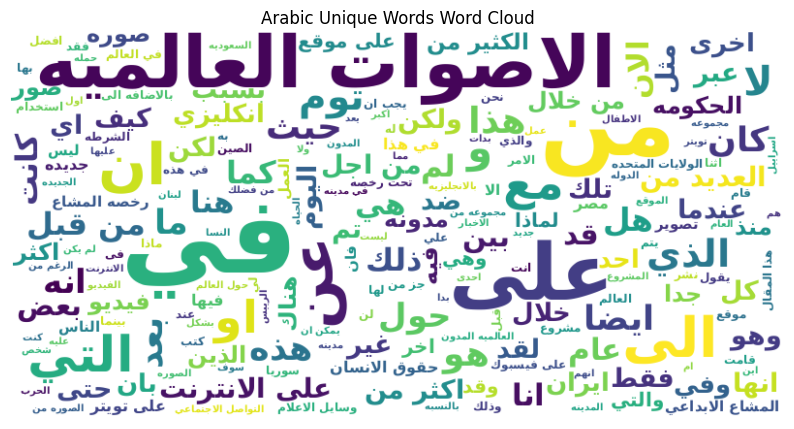

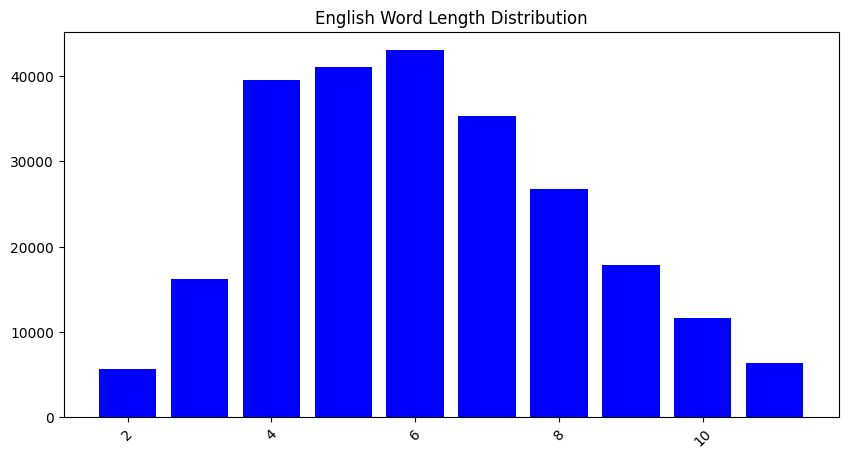

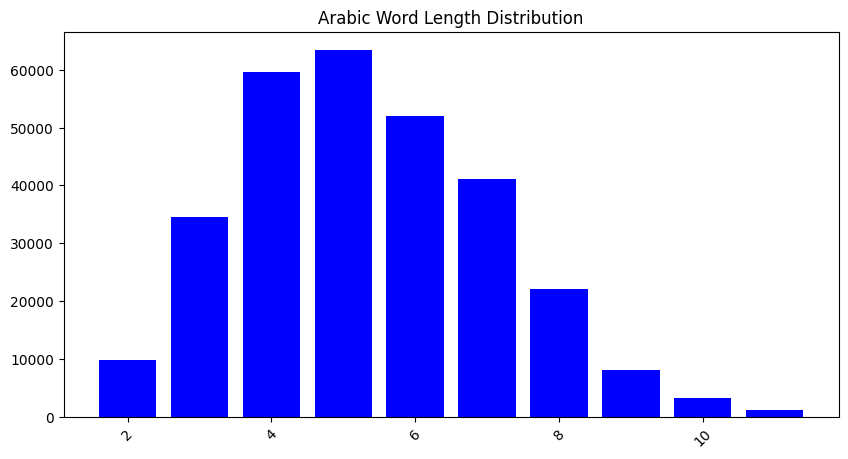

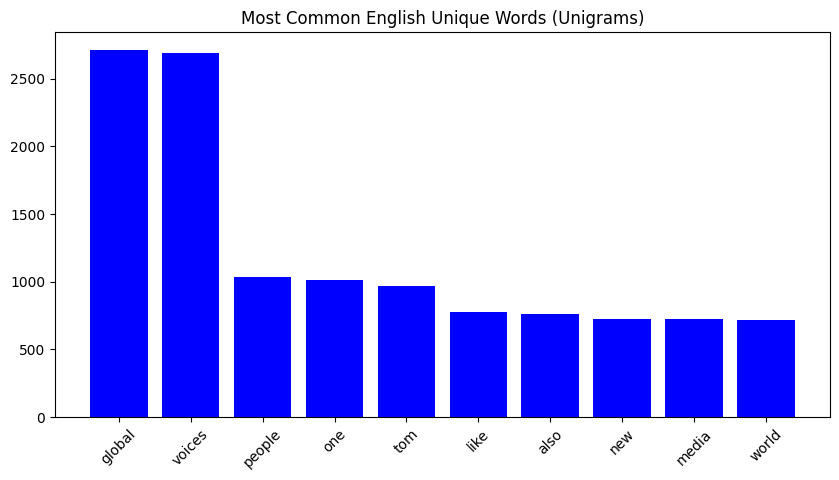

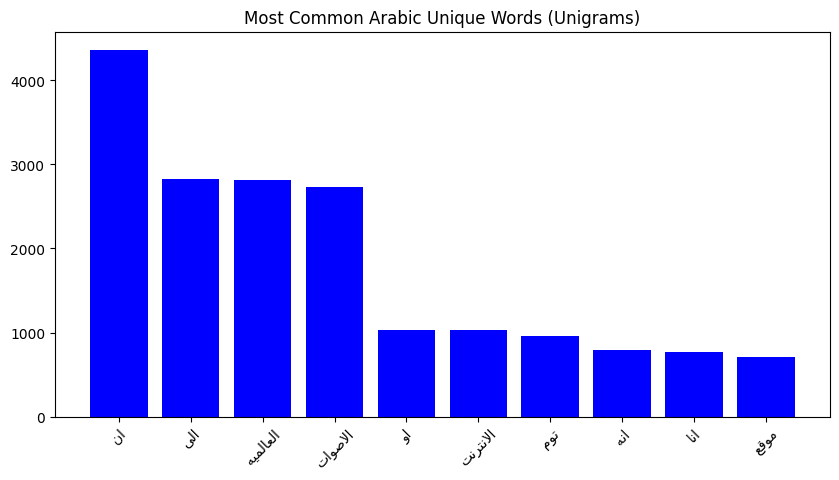

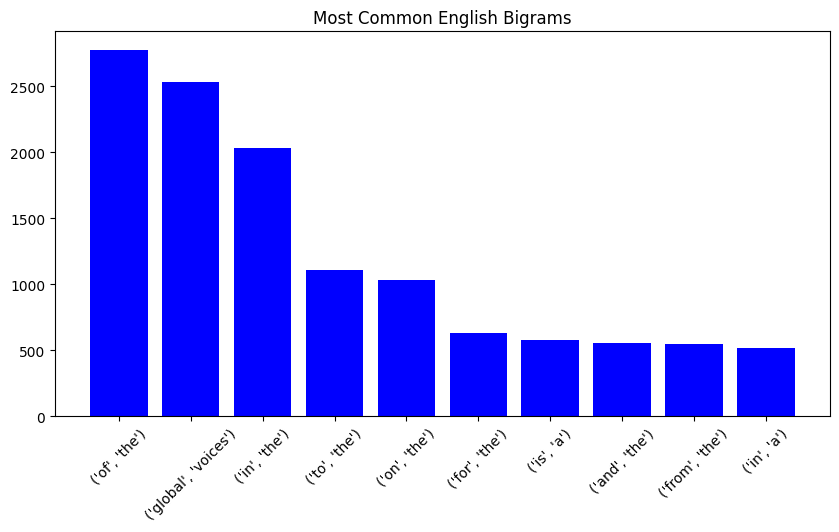

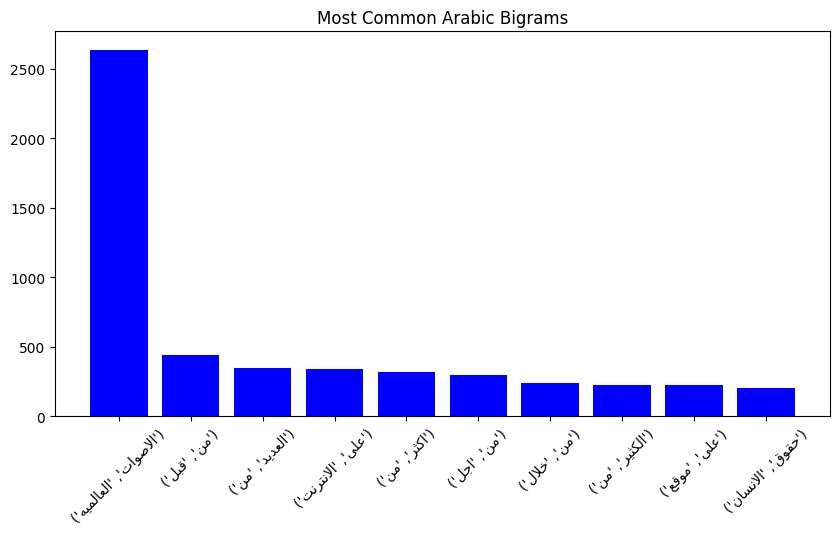

In [ ]:
def generate_bar_chart_eng(freq_list, title):
    words = [i[0] for i in freq_list]
    counts = [i[1] for i in freq_list]
    plt.figure(figsize=(10,5))
    plt.bar(words, counts, color='blue')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def generate_bar_chart_ar(freq_list, title):
    words = [i[0] for i in freq_list]
    counts = [i[1] for i in freq_list]
    reshaped_words = [get_display(arabic_reshaper.reshape(word)) for word in words]
    plt.figure(figsize=(10,5))
    plt.bar(reshaped_words, counts, color='blue')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def generate_word_cloud(freq_dict, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(freq_dict)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_word_cloud(freq_dist_eng_no_stopwords, 'English Unique Words Word Cloud')

wordcloud = WordCloud(font_path='/usr/local/lib/python3.10/dist-packages/cv2/qt/fonts/DejaVuSans-Bold.ttf',
                      width=800,
                      height=400,
                      random_state=21,
                      max_font_size=110,
                      background_color='white',
                      relative_scaling=0.5,
                      colormap='viridis').generate(' '.join(arabic_sentences_clean))
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Arabic Unique Words Word Cloud')
plt.show()

generate_bar_chart_eng(english_most_common_word_lengths, 'English Word Length Distribution')
generate_bar_chart_eng(arabic_most_common_word_lengths, 'Arabic Word Length Distribution')
generate_bar_chart_eng(english_most_common_no_stopwords, 'Most Common English Unique Words (Unigrams)')
generate_bar_chart_ar(arabic_most_common_no_stopwords, 'Most Common Arabic Unique Words (Unigrams)')

english_bigrams_counts = [(str(bigram), count) for bigram, count in english_bigram_freq.most_common(10)]
arabic_bigrams_counts = [(str(bigram), count) for bigram, count in arabic_bigram_freq.most_common(10)]
generate_bar_chart_eng(english_bigrams_counts, 'Most Common English Bigrams')
generate_bar_chart_ar(arabic_bigrams_counts, 'Most Common Arabic Bigrams')


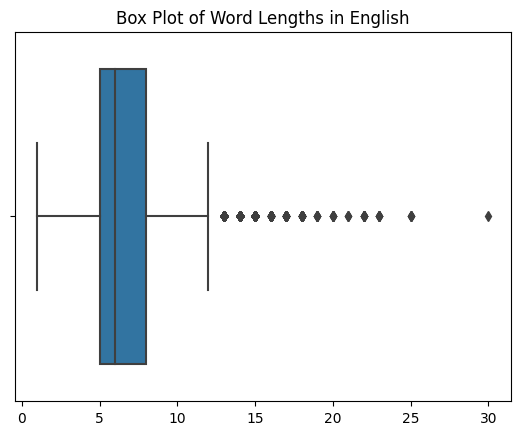

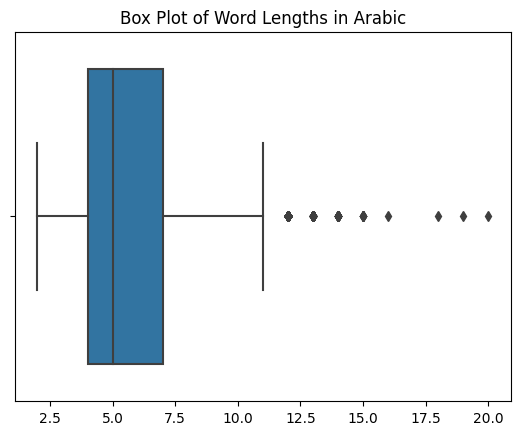

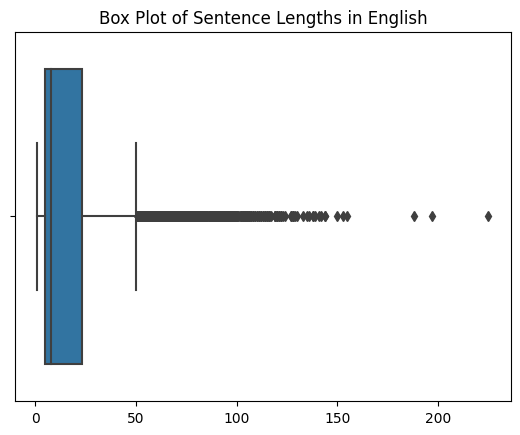

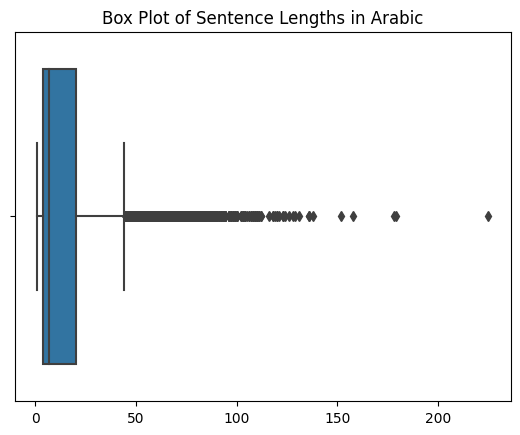

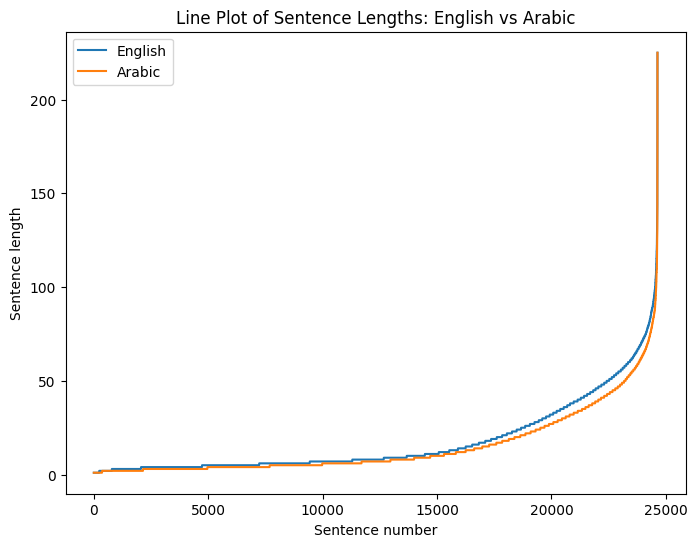

In [ ]:
import seaborn as sns

# Create box plots for word lengths
sns.boxplot(x=english_word_lengths).set_title('Box Plot of Word Lengths in English')
plt.show()
sns.boxplot(x=arabic_word_lengths).set_title('Box Plot of Word Lengths in Arabic')
plt.show()

# Create box plots for sentence lengths
sns.boxplot(x=english_sentence_lengths).set_title('Box Plot of Sentence Lengths in English')
plt.show()
sns.boxplot(x=arabic_sentence_lengths).set_title('Box Plot of Sentence Lengths in Arabic')
plt.show()

# Sort sentence lengths for line plot
english_sentence_lengths_sorted = sorted(english_sentence_lengths)
arabic_sentence_lengths_sorted = sorted(arabic_sentence_lengths)

# Plotting sentence lengths over the sentences
plt.figure(figsize=(8,6))
plt.plot(english_sentence_lengths_sorted, label='English')
plt.plot(arabic_sentence_lengths_sorted, label='Arabic')
plt.title('Line Plot of Sentence Lengths: English vs Arabic')
plt.xlabel('Sentence number')
plt.ylabel('Sentence length')
plt.legend()
plt.show()



# **Translation Models**

## **Simple LSTM Model**

In [11]:
src_vocab = src_vocab_size
tar_vocab = tar_vocab_size
src_timesteps = src_length
tar_timesteps = tar_length
n_units = 512

model = Sequential()
model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
model.add(LSTM(n_units))
model.add(RepeatVector(tar_timesteps))
model.add(LSTM(n_units, return_sequences=True))
model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
model.compile(optimizer='adam', loss='categorical_crossentropy')

history = model.fit(trainX, trainY, epochs=200, batch_size=64, validation_split=0.1, verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])



Epoch 1/200
125/125 [==============================] - 27s 112ms/step - loss: 3.0419 - val_loss: 3.6289
Epoch 2/200
125/125 [==============================] - 5s 42ms/step - loss: 2.3290 - val_loss: 3.5909
Epoch 3/200
125/125 [==============================] - 4s 35ms/step - loss: 2.2353 - val_loss: 3.6633
Epoch 4/200
125/125 [==============================] - 4s 31ms/step - loss: 2.1753 - val_loss: 3.7213
Epoch 5/200
125/125 [==============================] - 4s 28ms/step - loss: 2.1298 - val_loss: 3.6879
Epoch 6/200
125/125 [==============================] - 4s 30ms/step - loss: 2.1080 - val_loss: 3.7161
Epoch 7/200
125/125 [==============================] - 4s 32ms/step - loss: 2.0419 - val_loss: 3.7580


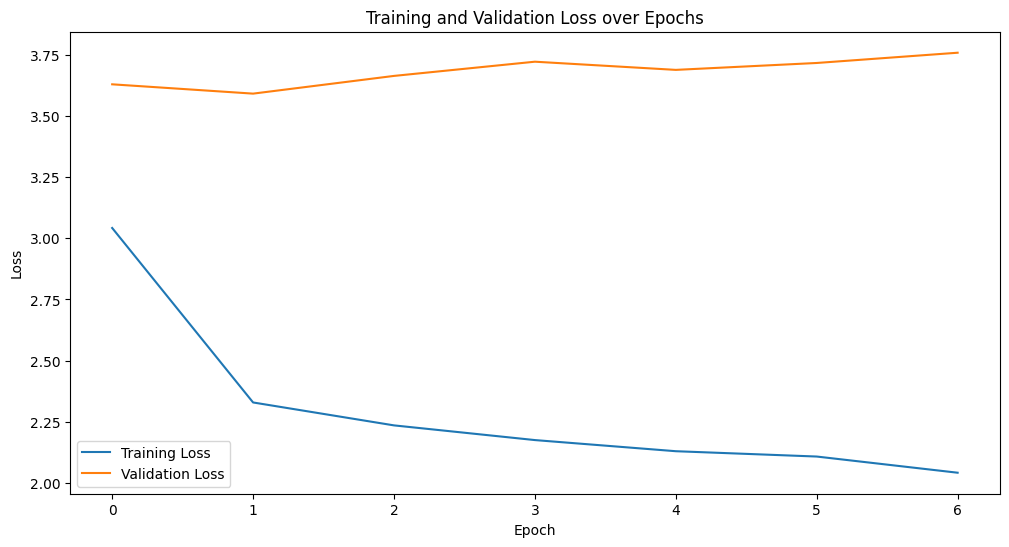

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_seq(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = [word_for_id(i, tokenizer) for i in integers if word_for_id(i, tokenizer) is not None]
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset_ar, raw_dataset_en, limit=20):
    print(f"{'(SOURCE) Arabic':30} {'(TARGET) English':25} {'AUTOMATIC TRANSLATION IN English'}")
    for i, source in enumerate(sources):
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tokenizer, source)
        raw_target, raw_src = raw_dataset_en[i], raw_dataset_ar[i]
        print(f"{raw_src:30} {raw_target:25} {translation}")
        if i >= limit:
            break

compare_prediction(model, tar_tokenizer, trainX, train_ar, train_en)
compare_prediction(model, tar_tokenizer, testX, test_ar, test_en)

### Result on the Training Set ###
(SOURCE) Arabic                (TARGET) English          AUTOMATIC TRANSLATION IN English

<bos> مرحبا <eos>              <bos> hi <eos>            bos i eos eos
<bos> اركض <eos>               <bos> run <eos>           bos i you eos
<bos> النجده <eos>             <bos> help <eos>          bos i eos
<bos> اقفز <eos>               <bos> jump <eos>          bos i you eos
<bos> قف <eos>                 <bos> stop <eos>          bos i you eos
<bos> داوم <eos>               <bos> go on <eos>         bos i you eos
<bos> استمر <eos>              <bos> go on <eos>         bos i eos eos
<bos> مرحبا <eos>              <bos> hello <eos>         bos i eos eos
<bos> تعجل <eos>               <bos> hurry <eos>         bos i eos eos
<bos> استعجل <eos>             <bos> hurry <eos>         bos i eos eos
<bos> انا اري <eos>            <bos> i see <eos>         bos i you eos
<bos> انا فزت <eos>            <bos> i won <eos>         bos i eos eos
<bos> استرح <eos>         

In [16]:
def calculate_bleu_score(model, tokenizer, sources, raw_targets):
    actual, predicted = [], []
    for i, source in enumerate(sources):
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tokenizer, source)
        raw_target = raw_targets[i].split()
        predicted.append(translation.split())
        actual.append([raw_target])
    return corpus_bleu(actual, predicted)

test_bleu = calculate_bleu_score(model, tar_tokenizer, testX, test_en)
print(f"Testing BLEU Score: {test_bleu:.4f}")

Testing BLEU Score: 0.0000


#### **Inference Function**

In [ ]:
def translate(model, src_tokenizer, tar_tokenizer, src_length, source):
    source_seq = encode_sequences(src_tokenizer, src_length, [source])
    prediction = model.predict(source_seq, verbose=0)[0]
    int_seq = [np.argmax(vector) for vector in prediction]
    target_text = ' '.join([tar_tokenizer.index_word[i] for i in int_seq if i > 0])
    return target_text

sentence = "مرحبا"
translation = translate(model, src_tokenizer, tar_tokenizer, src_length, sentence)
print(f'Arabic: {sentence}\nPredicted English: {translation}')

Arabic: مرحبا
Predicted English: though though though painful painful painful painful painful painful painful painful painful painful



## **enc-dec model**

### without Attention

In [17]:
src_vocab = src_vocab_size
tar_vocab = tar_vocab_size
src_timesteps = src_length
tar_timesteps = tar_length
n_units = 512

encoder_inputs = Input(shape=(src_timesteps,))
enc_emb = Embedding(src_vocab, n_units, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(tar_timesteps,))
dec_emb_layer = Embedding(tar_vocab, n_units, mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = TimeDistributed(Dense(tar_vocab, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
opt = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=opt, loss='categorical_crossentropy')

decoder_input_data = np.zeros_like(trainY)
decoder_input_data[:, 1:] = trainY[:, :-1]
decoder_input_data = np.argmax(decoder_input_data, axis=-1)

history = model.fit(
    [trainX, decoder_input_data],
    trainY,
    epochs=200,
    batch_size=18,
    validation_split=0.1,
    verbose=1,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/200
444/444 [==============================] - 41s 73ms/step - loss: 4.2583 - val_loss: 4.4788
Epoch 2/200
444/444 [==============================] - 34s 76ms/step - loss: 3.4352 - val_loss: 4.1769
Epoch 3/200
444/444 [==============================] - 31s 71ms/step - loss: 2.8264 - val_loss: 3.9597
Epoch 4/200
444/444 [==============================] - 31s 69ms/step - loss: 2.2157 - val_loss: 3.9010
Epoch 5/200
444/444 [==============================] - 31s 69ms/step - loss: 1.6877 - val_loss: 3.8983
Epoch 6/200
444/444 [==============================] - 30s 68ms/step - loss: 1.2444 - val_loss: 3.9448
Epoch 7/200
444/444 [==============================] - 30s 68ms/step - loss: 0.8907 - val_loss: 4.0263
Epoch 8/200
444/444 [==============================] - 30s 67ms/step - loss: 0.6135 - val_loss: 4.1429
Epoch 9/200
444/444 [==============================] - 30s 68ms/step - loss: 0.4099 - val_loss: 4.2615
Epoch 10/200
444/444 [==============================] - 32s 72ms/step - l

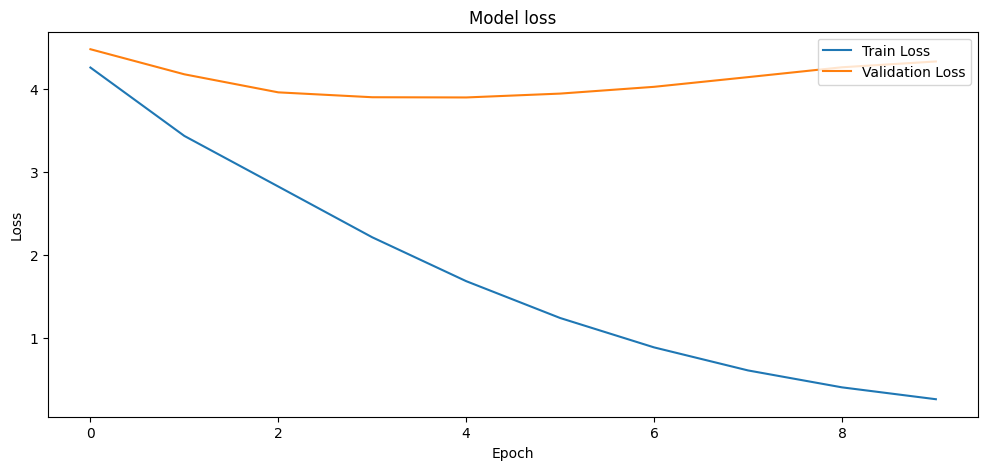

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [24]:
def predict_seq(encoder_model, decoder_model, tokenizer, source, max_output_length):
    state_h, state_c = encoder_model.predict(source, verbose=0)
    encoder_states = [state_h, state_c]
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['<bos>']
    decoded_sentence = []

    for _ in range(max_output_length):
        output_tokens, h, c = decoder_model.predict([target_seq] + encoder_states, verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = word_for_id(sampled_token_index, tokenizer)

        if sampled_word is None or sampled_word == '<eos>':
            break

        decoded_sentence.append(sampled_word)
        encoder_states = [h, c]
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

    return ' '.join(decoded_sentence)

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def compare_prediction(encoder_model, decoder_model, tokenizer, sources, raw_dataset_ar, raw_dataset_en, max_output_length, limit=20):
    actual, predicted = [], []
    src = '(SOURCE) Arabic'
    tgt = '(TARGET) English'
    pred = 'AUTOMATIC TRANSLATION IN English'
    print(f'{src:30} {tgt:25} {pred}\n')

    for i, source in enumerate(sources):
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(encoder_model, decoder_model, tokenizer, source, max_output_length)
        raw_target, raw_src = raw_dataset_en[i], raw_dataset_ar[i]
        print(f'{raw_src:30} {raw_target:25} {translation}')
        if i >= limit:
            break

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

print('### Result on the Training Set ###')
compare_prediction(encoder_model, decoder_model, tar_tokenizer, trainX, train_ar, train_en, tar_length)

print('\n\n### Result on the Test Set ###')
compare_prediction(encoder_model, decoder_model, tar_tokenizer, testX, test_ar, test_en, tar_length)


### Result on the Training Set ###
(SOURCE) Arabic                (TARGET) English          AUTOMATIC TRANSLATION IN English

<bos> مرحبا <eos>              <bos> hi <eos>            eos
<bos> اركض <eos>               <bos> run <eos>           eos
<bos> النجده <eos>             <bos> help <eos>          eos
<bos> اقفز <eos>               <bos> jump <eos>          eos
<bos> قف <eos>                 <bos> stop <eos>          eos
<bos> داوم <eos>               <bos> go on <eos>         the car eos
<bos> استمر <eos>              <bos> go on <eos>         the room eos
<bos> مرحبا <eos>              <bos> hello <eos>         eos
<bos> تعجل <eos>               <bos> hurry <eos>         eos
<bos> استعجل <eos>             <bos> hurry <eos>         eos
<bos> انا اري <eos>            <bos> i see <eos>         i am eos
<bos> انا فزت <eos>            <bos> i won <eos>         i am eos
<bos> استرح <eos>              <bos> relax <eos>         well eos
<bos> ابتسم <eos>              <bos> smile <eos> 

In [13]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu

def generate_translation(encoder_model, decoder_model, tokenizer, source, max_output_length):
    translation = predict_seq(encoder_model, decoder_model, tokenizer, source, max_output_length)
    return translation.split()

def compute_bleu(encoder_model, decoder_model, tokenizer, sources, references, max_output_length):
    predicted_translations = [generate_translation(encoder_model, decoder_model, tokenizer, src.reshape((1, src.shape[0])), max_output_length) for src in sources]
    bleu_scores = [sentence_bleu([ref.split()], pred) for ref, pred in zip(references, predicted_translations)]
    return np.mean(bleu_scores)

bleu_score_test = compute_bleu(encoder_model, decoder_model, tar_tokenizer, testX, test_en, tar_length)
print(f'BLEU score on the test set: {bleu_score_test:.4f}')


BLEU score on the test set: 0.0048


#### **Inference Function**

In [25]:
def translate_sentence(sentence, encoder_model, decoder_model, src_tokenizer, tar_tokenizer, max_output_length):
    tokenized_sentence = src_tokenizer.texts_to_sequences([sentence])
    padded_tokenized_sentence = pad_sequences(tokenized_sentence, maxlen=max_output_length, padding='post')

    translated_sentence = predict_seq(encoder_model, decoder_model, tar_tokenizer, padded_tokenized_sentence, max_output_length)

    return translated_sentence

In [29]:
arabic_sentence = "حين اكبر اريد ان اصبح ملكا قويا"
translation = translate_sentence(arabic_sentence, encoder_model, decoder_model, src_tokenizer, tar_tokenizer, src_length)
print(f"Original: {arabic_sentence}\nTranslation: {translation}")

Original: حين اكبر اريد ان اصبح ملكا قويا
Translation: i was busy for a doctor eos


### With Attention

In [30]:
src_vocab = src_vocab_size
tar_vocab = tar_vocab_size
src_timesteps = src_length
tar_timesteps = tar_length
n_units = 512

encoder_inputs = Input(shape=(src_timesteps,))
enc_emb = Embedding(src_vocab, n_units, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(tar_timesteps,))
dec_emb_layer = Embedding(tar_vocab, n_units, mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

attention = Attention(use_scale=True, name='attention')
attn_out = attention([decoder_outputs, encoder_outputs])

decoder_concat_input = tf.keras.layers.Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_dense = TimeDistributed(Dense(tar_vocab, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

opt = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=opt, loss='categorical_crossentropy')

decoder_input_data = np.zeros_like(trainY)
decoder_input_data[:, 1:] = trainY[:, :-1]

decoder_input_data = np.argmax(decoder_input_data, axis=-1)

history = model.fit(
    [trainX, decoder_input_data],
    trainY,
    epochs=200,
    batch_size=18,
    validation_split=0.1,
    verbose=1,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)


Epoch 1/200
444/444 [==============================] - 41s 76ms/step - loss: 4.2133 - val_loss: 4.3549
Epoch 2/200
444/444 [==============================] - 32s 73ms/step - loss: 3.1055 - val_loss: 3.9852
Epoch 3/200
444/444 [==============================] - 31s 70ms/step - loss: 2.3073 - val_loss: 3.8499
Epoch 4/200
444/444 [==============================] - 31s 69ms/step - loss: 1.6108 - val_loss: 3.8983
Epoch 5/200
444/444 [==============================] - 32s 71ms/step - loss: 1.0444 - val_loss: 4.0650
Epoch 6/200
444/444 [==============================] - 31s 70ms/step - loss: 0.6194 - val_loss: 4.2095
Epoch 7/200
444/444 [==============================] - 31s 71ms/step - loss: 0.3579 - val_loss: 4.3600
Epoch 8/200
444/444 [==============================] - 32s 71ms/step - loss: 0.2198 - val_loss: 4.5281


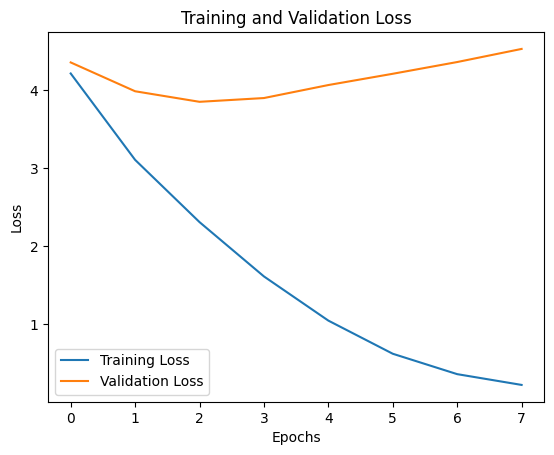

In [31]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [36]:
def predict_seq(encoder_model, decoder_model, tokenizer, source, max_output_length):
    encoder_out_and_states = encoder_model.predict(source, verbose=0)
    encoder_outputs = encoder_out_and_states[0]
    state_h, state_c = encoder_out_and_states[1], encoder_out_and_states[2]
    encoder_states = [state_h, state_c]

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['<bos>']

    decoded_sentence = []
    for _ in range(max_output_length):
        output_tokens, h, c = decoder_model.predict([target_seq, encoder_outputs] + encoder_states, verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = word_for_id(sampled_token_index, tokenizer)

        if sampled_word is None or sampled_word == '<eos>':
            break

        decoded_sentence.append(sampled_word)

        encoder_states = [h, c]
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

    return ' '.join(decoded_sentence)

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def compare_prediction(encoder_model, decoder_model, tokenizer, sources, raw_dataset_ar, raw_dataset_en, max_output_length, limit=20):
    actual, predicted = [], []
    src = '(SOURCE) Arabic'
    tgt = '(TARGET) English'
    pred = 'AUTOMATIC TRANSLATION IN English'
    print(f'{src:30} {tgt:25} {pred}\n')

    for i, source in enumerate(sources):
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(encoder_model, decoder_model, tokenizer, source, max_output_length)
        raw_target, raw_src = raw_dataset_en[i], raw_dataset_ar[i]
        print(f'{raw_src:30} {raw_target:25} {translation}')
        if i >= limit:
            break

encoder_model = Model(encoder_inputs, [encoder_outputs] + encoder_states)


decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

encoder_outputs_input = Input(shape=(src_timesteps, n_units))
attn_out2 = attention([decoder_outputs2, encoder_outputs_input])
decoder_concat_input2 = Concatenate(axis=-1, name='concat_layer_2')([decoder_outputs2, attn_out2])
decoder_outputs2 = decoder_dense(decoder_concat_input2)

decoder_model = Model(
    [decoder_inputs, encoder_outputs_input] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)


print('### Result on the Training Set ###')
compare_prediction(encoder_model, decoder_model, tar_tokenizer, trainX, train_ar, train_en, tar_length)

print('\n\n### Result on the Test Set ###')
compare_prediction(encoder_model, decoder_model, tar_tokenizer, testX, test_ar, test_en, tar_length)


### Result on the Training Set ###
(SOURCE) Arabic                (TARGET) English          AUTOMATIC TRANSLATION IN English



<bos> مرحبا <eos>              <bos> hi <eos>            succeeded eos
<bos> اركض <eos>               <bos> run <eos>           succeeded succeeded bunch bunch divorce divorce divorce divorce does it like me eos
<bos> النجده <eos>             <bos> help <eos>          eos
<bos> اقفز <eos>               <bos> jump <eos>          eos
<bos> قف <eos>                 <bos> stop <eos>          eos
<bos> داوم <eos>               <bos> go on <eos>         eos
<bos> استمر <eos>              <bos> go on <eos>         eos
<bos> مرحبا <eos>              <bos> hello <eos>         succeeded eos
<bos> تعجل <eos>               <bos> hurry <eos>         succeeded succeeded bunch divorce divorce divorce divorce divorce course cab i have to
<bos> استعجل <eos>             <bos> hurry <eos>         succeeded succeeded succeeded divorce divorce divorce course those are you doing eos
<bos> انا اري <eos>            <bos> i see <eos>         eos
<bos> انا فزت <eos>            <bos> i won <eos>         honest h

In [15]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu

def generate_translation(encoder_model, decoder_model, tokenizer, source, max_output_length):
    translation = predict_seq(encoder_model, decoder_model, tokenizer, source, max_output_length)
    return translation.split()

def compute_bleu(encoder_model, decoder_model, tokenizer, sources, references, max_output_length):
    predicted_translations = [generate_translation(encoder_model, decoder_model, tokenizer, src.reshape((1, src.shape[0])), max_output_length) for src in sources]
    bleu_scores = [sentence_bleu([ref.split()], pred) for ref, pred in zip(references, predicted_translations)]
    return np.mean(bleu_scores)

bleu_score_test = compute_bleu(encoder_model, decoder_model, tar_tokenizer, testX, test_en, tar_length)
print(f'BLEU score on the test set: {bleu_score_test:.4f}')


BLEU score on the test set: 0.0063


#### **Inference Function**

In [37]:
def translate_sentence(sentence, encoder_model, decoder_model, src_tokenizer, tar_tokenizer, max_output_length):
    tokenized_sentence = src_tokenizer.texts_to_sequences([sentence])
    padded_tokenized_sentence = pad_sequences(tokenized_sentence, maxlen=max_output_length, padding='post')

    translated_sentence = predict_seq(encoder_model, decoder_model, tar_tokenizer, padded_tokenized_sentence, max_output_length)

    return translated_sentence



In [38]:
arabic_sentence = "حين اكبر اريد ان اصبح ملكا قويا"
translation = translate_sentence(arabic_sentence, encoder_model, decoder_model, src_tokenizer, tar_tokenizer, src_length)
print(f"Original: {arabic_sentence}\nTranslation: {translation}")


Original: حين اكبر اريد ان اصبح ملكا قويا
Translation: would you want to do it eos


## ***Analysis:***


* **Overfitting:** All three models exhibit signs of overfitting. As
training progresses, validation loss rises after a few epochs, while training loss steadily decreases. This suggests that while the models are fitting well to the training data dues to the amount of the data and the complexity of the models.

* **Translation Quality:** The Encoder-Decoder with Attention model delivered the highest BLEU score, indicating best translation performance. Yet, all models displayed challenges in generating entirely accurate translations, with repeated tokens commonly observed.

* **Model Complexity:** As the models progressed from the simple LSTM network to LSTM encoder-decoder and then to the attention mechanism, their complexity increased. This added complexity led to some improvements in translation quality.

## **Why the Encoder-Decoder with Attention Model is the Best:**

* **Handles Long Sequences Better:** Traditional encoder-decoder models might forget some parts of a long input when converting it to a fixed-size vector. The attention mechanism lets the model focus on different input parts when producing each output, reducing information loss.

* **Selective Focus:** The model doesn't treat all input words equally. It gives more importance to the words that are more relevant to the current word being translated, which results in better translation accuracy.

* **Complex Sentences:** Especially when translating between languages with different sentence structures, having attention helps the model pick out and rearrange the right information.

## **Pretrained Models**

In [ ]:
english_sentences_clean = [clean_english_text(sentence) for sentence in english_sentences]
arabic_sentences_clean = [clean_arabic_text(sentence) for sentence in arabic_sentences]

zero_length_english_indices = [i for i, sentence in enumerate(english_sentences_clean) if len(sentence.split()) == 0]
zero_length_arabic_indices = [i for i, sentence in enumerate(arabic_sentences_clean) if len(sentence.split()) == 0]

indices_to_remove = set(zero_length_english_indices + zero_length_arabic_indices)

english_sentences_clean = [sentence for i, sentence in enumerate(english_sentences_clean) if i not in indices_to_remove]
arabic_sentences_clean = [sentence for i, sentence in enumerate(arabic_sentences_clean) if i not in indices_to_remove]

### **Marian NMT**

In [23]:
model_name = "Helsinki-NLP/opus-mt-ar-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
MAX_LENGTH = 256

def tokenize_data(arabic, english):
    tokenized_data = tokenizer.prepare_seq2seq_batch(src_texts=arabic,
                                                     tgt_texts=english,
                                                     max_length=MAX_LENGTH,
                                                     padding="max_length",
                                                     return_tensors="pt",
                                                     truncation=True)
    return tokenized_data

tokenized_datasets = tokenize_data(arabic_sentences_clean, english_sentences_clean)

class CustomDataset(Dataset):
    def __init__(self, tokenized_data):
        self.input_ids = tokenized_data["input_ids"]
        self.attention_mask = tokenized_data["attention_mask"]
        self.target_ids = tokenized_data["labels"]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.target_ids[idx]
        }

full_dataset = CustomDataset(tokenized_datasets)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
model = MarianMTModel.from_pretrained(model_name)

training_args = TrainingArguments(
    output_dir="./results_marian",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    evaluation_strategy="steps",
    save_strategy="steps",
    logging_dir="./logs_marian",
    logging_steps=1000,
    eval_steps=1000,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    push_to_hub=False,
    logging_first_step=True,
    report_to=["tensorboard"]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3786: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `pr

Step,Training Loss,Validation Loss
1000,0.300300,0.208516
2000,0.221700,0.199570
3000,0.209900,0.194595
4000,0.210600,0.190348
5000,0.206300,0.188673
6000,0.157700,0.187283
7000,0.165500,0.187902
8000,0.164800,0.185881
9000,0.162700,0.184721
10000,0.145300,0.186031


TrainOutput(global_step=24640, training_loss=0.14302249024440716, metrics={'train_runtime': 6968.6279, 'train_samples_per_second': 14.141, 'train_steps_per_second': 3.536, 'total_flos': 6681028743659520.0, 'train_loss': 0.14302249024440716, 'epoch': 5.0})

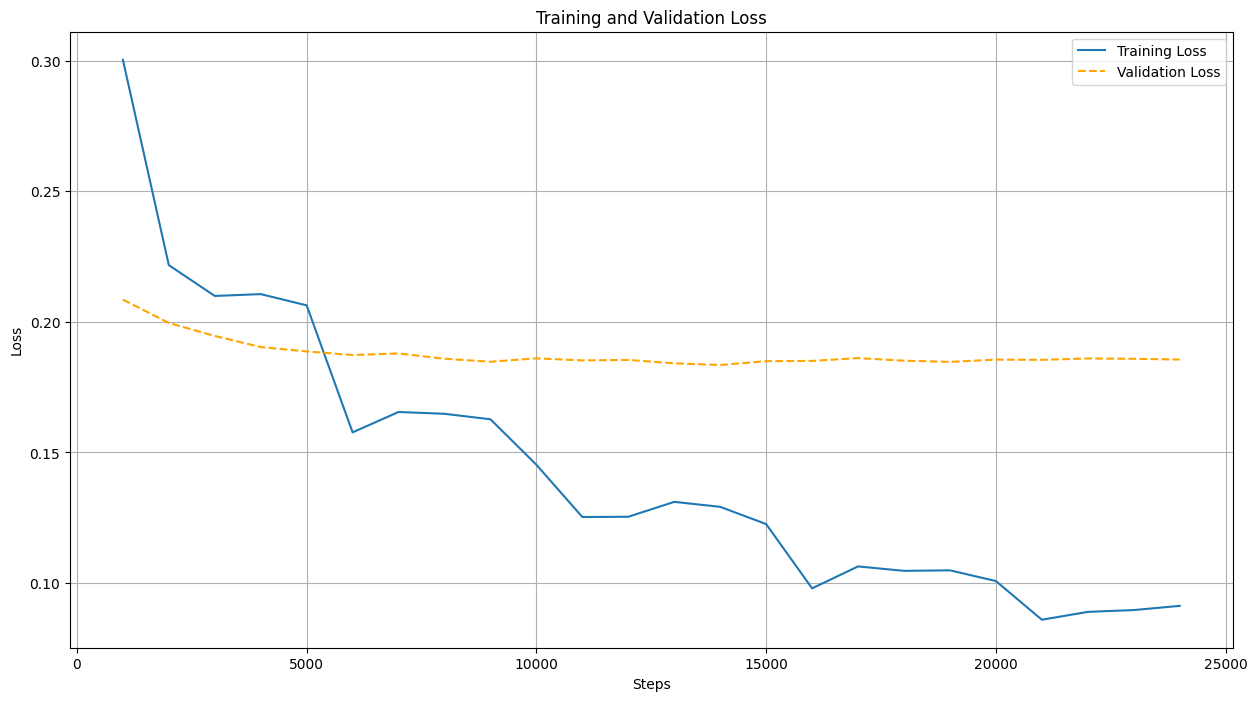

In [24]:
logs = trainer.state.log_history
train_steps = [x['step'] for x in logs if 'loss' in x][1:]
train_loss = [x['loss'] for x in logs if 'loss' in x][1:]
eval_steps = [x['step'] for x in logs if 'eval_loss' in x]
eval_loss = [x['eval_loss'] for x in logs if 'eval_loss' in x]

plt.figure(figsize=(15, 8))
plt.plot(train_steps, train_loss, label='Training Loss')
plt.plot(eval_steps, eval_loss, label='Validation Loss', linestyle='--', color='orange')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_bleu(model, dataset, tokenizer):
    reference_texts = []
    translated_texts = []

    for data in dataset:
        data = {key: val.to(device) for key, val in data.items()}
        reference_text = tokenizer.decode(data["labels"], skip_special_tokens=True)
        reference_texts.append(reference_text)

        model.eval()
        with torch.no_grad():
            output = model.generate(data["input_ids"].unsqueeze(0), attention_mask=data["attention_mask"].unsqueeze(0))
        translated_texts.append(tokenizer.decode(output[0], skip_special_tokens=True))

    bleu_score = sacrebleu.corpus_bleu(translated_texts, [reference_texts])
    return bleu_score.score

bleu = compute_bleu(model, val_dataset, tokenizer)

In [26]:
print(f"Bleu Score: {bleu:.2f}")

Bleu Score: 28.65


#### **Inference**

In [27]:
def translate(sentence, model, tokenizer, device="cuda"):
    model = model.to(device).eval()
    tokenized = tokenizer.encode(sentence, return_tensors="pt", truncation=True, padding="max_length", max_length=MAX_LENGTH).to(device)
    translated = model.generate(tokenized, num_beams=4, max_length=40, early_stopping=True)
    translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)
    return translated_text

arabic_sentence = "عايز اكل"
english_translation = translate(arabic_sentence, model, tokenizer)
print(f"Original: {arabic_sentence}\nTranslation: {english_translation}")

Original: عايز اكل
Translation: i want to eat


### **MBART**

In [ ]:
tokenizer = MBartTokenizer.from_pretrained("facebook/mbart-large-cc25")
MAX_LENGTH = 230

def tokenize_data(english, arabic):
    tokenized_data = tokenizer.prepare_seq2seq_batch(src_texts=arabic,
                                                     tgt_texts=english,
                                                     src_lang="ar_AR",
                                                     tgt_lang="en_XX",
                                                     max_length=MAX_LENGTH,
                                                     padding="max_length",
                                                     return_tensors="pt",
                                                     truncation=True)
    return tokenized_data

tokenized_datasets = tokenize_data(english_sentences_clean, arabic_sentences_clean)

class CustomDataset(Dataset):
    def __init__(self, tokenized_data):
        self.input_ids = tokenized_data["input_ids"]
        self.attention_mask = tokenized_data["attention_mask"]
        self.target_ids = tokenized_data["labels"]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.target_ids[idx]
        }

full_dataset = CustomDataset(tokenized_datasets)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-cc25")
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    evaluation_strategy="steps",
    save_strategy="steps",
    logging_dir="./logs",
    logging_steps=1000,
    eval_steps=1000,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    push_to_hub=False,
    logging_first_step=True,
    report_to=["tensorboard"]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

trainer.train()

/l/users/ahmed.aboeitta/espnet/tools/anaconda/envs/espnet/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3766: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


/l/users/ahmed.aboeitta/espnet/tools/anaconda/envs/espnet/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3640: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


/l/users/ahmed.aboeitta/espnet/tools/anaconda/envs/espnet/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,0.850900,0.311119
2000,0.315400,0.272992
3000,0.306100,0.709522
4000,0.305400,0.249865
5000,0.263800,0.240039
6000,0.188600,0.235287
7000,0.187900,0.229578
8000,0.188300,0.225422
9000,0.185900,0.221060
10000,0.167400,0.234320


TrainOutput(global_step=24640, training_loss=0.1625452343519632, metrics={'train_runtime': 10758.7544, 'train_samples_per_second': 9.16, 'train_steps_per_second': 2.29, 'total_flos': 4.79675338727424e+16, 'train_loss': 0.1625452343519632, 'epoch': 5.0})

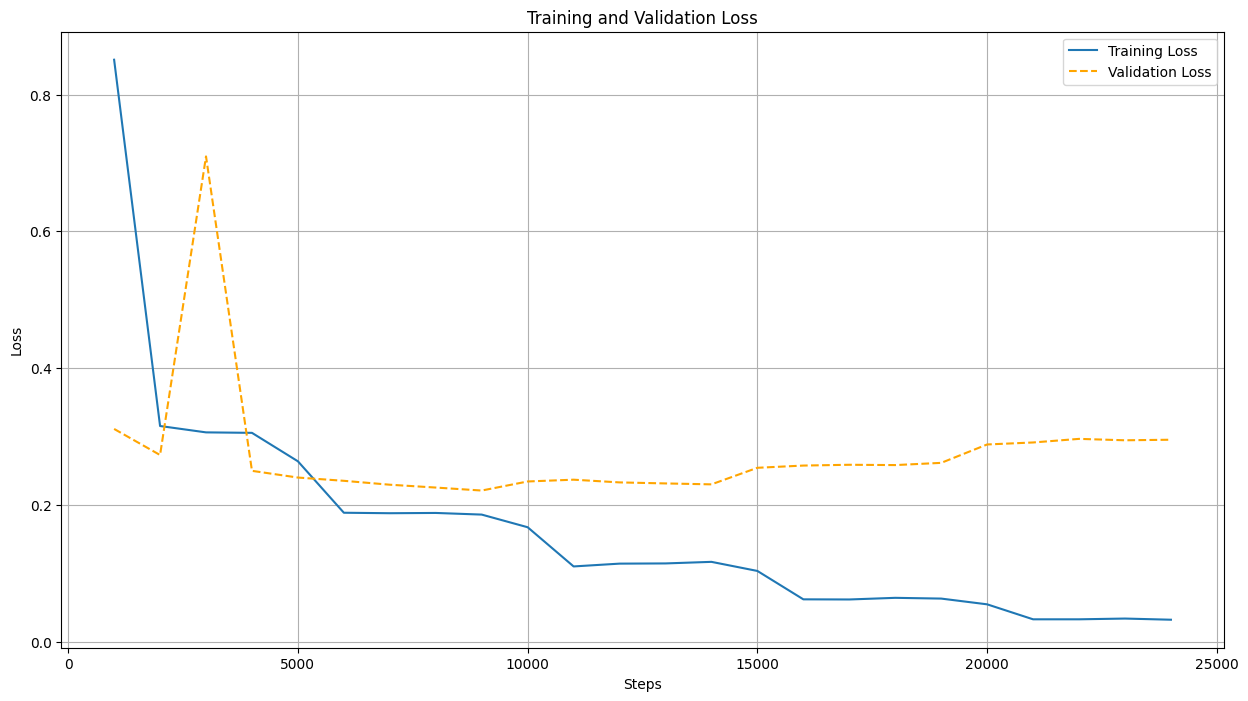

In [ ]:
logs = trainer.state.log_history
train_steps = [x['step'] for x in logs if 'loss' in x][1:]
train_loss = [x['loss'] for x in logs if 'loss' in x][1:]
eval_steps = [x['step'] for x in logs if 'eval_loss' in x]
eval_loss = [x['eval_loss'] for x in logs if 'eval_loss' in x]

plt.figure(figsize=(15, 8))
plt.plot(train_steps, train_loss, label='Training Loss')
plt.plot(eval_steps, eval_loss, label='Validation Loss', linestyle='--', color='orange')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_bleu(model, dataset, tokenizer):
    reference_texts = []
    translated_texts = []

    for data in dataset:
        data = {key: val.to(device) for key, val in data.items()}
        reference_text = tokenizer.decode(data["labels"], skip_special_tokens=True)
        reference_texts.append(reference_text)

        model.eval()
        with torch.no_grad():
            output = model.generate(data["input_ids"].unsqueeze(0), attention_mask=data["attention_mask"].unsqueeze(0))
        translated_texts.append(tokenizer.decode(output[0], skip_special_tokens=True))

    bleu_score = sacrebleu.corpus_bleu(translated_texts, [reference_texts])
    return bleu_score.score

bleu = compute_bleu(model, val_dataset, tokenizer)

/l/users/ahmed.aboeitta/espnet/tools/anaconda/envs/espnet/lib/python3.8/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (1024) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
print(f"Bleu Score: {bleu:.2f}")

Bleu Score: 20.47


#### **Inference**

In [ ]:
def translate_arabic_to_english_mbart(model, tokenizer, arabic_sentence, device):
    model.to(device).eval()
    inputs = tokenizer.prepare_seq2seq_batch(src_texts=[arabic_sentence],
                                             src_lang="ar_AR",
                                             tgt_lang="en_XX",
                                             return_tensors="pt",
                                             max_length=MAX_LENGTH,
                                             truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=MAX_LENGTH, num_beams=4, early_stopping=True)
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translated_text

arabic_test_sentence = "مرحبا بكم في المكتبة"
translated_sentence = translate_arabic_to_english_mbart(model, tokenizer, arabic_test_sentence, device)
print(translated_sentence)

welcome to the library


/l/users/ahmed.aboeitta/espnet/tools/anaconda/envs/espnet/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3766: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


### **MT5**

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google/mt5-small")
MAX_LENGTH = 230

def tokenize_data(english, arabic):
    source_texts = ['translate Arabic to English: ' + txt for txt in arabic]
    tokenized_data = tokenizer.prepare_seq2seq_batch(src_texts=source_texts,
                                                     tgt_texts=english,
                                                     max_length=MAX_LENGTH,
                                                     padding="max_length",
                                                     return_tensors="pt",
                                                     truncation=True)
    return tokenized_data

tokenized_datasets = tokenize_data(english_sentences_clean, arabic_sentences_clean)

class CustomDataset(Dataset):
    def __init__(self, tokenized_data):
        self.input_ids = tokenized_data["input_ids"]
        self.attention_mask = tokenized_data["attention_mask"]
        self.target_ids = tokenized_data["labels"]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.target_ids[idx]
        }

full_dataset = CustomDataset(tokenized_datasets)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

model = MT5ForConditionalGeneration.from_pretrained("google/mt5-base")
training_args = TrainingArguments(
    output_dir="./results_mt5",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    evaluation_strategy="steps",
    save_strategy="steps",
    logging_dir="./logs_mt5",
    logging_steps=1000,
    eval_steps=1000,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    push_to_hub=False,
    logging_first_step=True,
    report_to=["tensorboard"]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()

You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


/l/users/ahmed.aboeitta/espnet/tools/anaconda/envs/espnet/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3766: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


/l/users/ahmed.aboeitta/espnet/tools/anaconda/envs/espnet/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3640: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


/l/users/ahmed.aboeitta/espnet/tools/anaconda/envs/espnet/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
1000,5.927500,0.397690
2000,1.699600,0.599655
3000,0.464500,0.293149
4000,0.386800,0.276444
5000,0.353600,0.265021
6000,0.336000,0.257099
7000,0.323200,0.252382
8000,0.316100,0.248572
9000,0.308200,0.248147
10000,0.305300,0.246280


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ahmed.aboeitta/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=12320, training_loss=0.9058312131212903, metrics={'train_runtime': 7155.2974, 'train_samples_per_second': 27.545, 'train_steps_per_second': 1.722, 'total_flos': 1.061593759429632e+17, 'train_loss': 0.9058312131212903, 'epoch': 10.0})

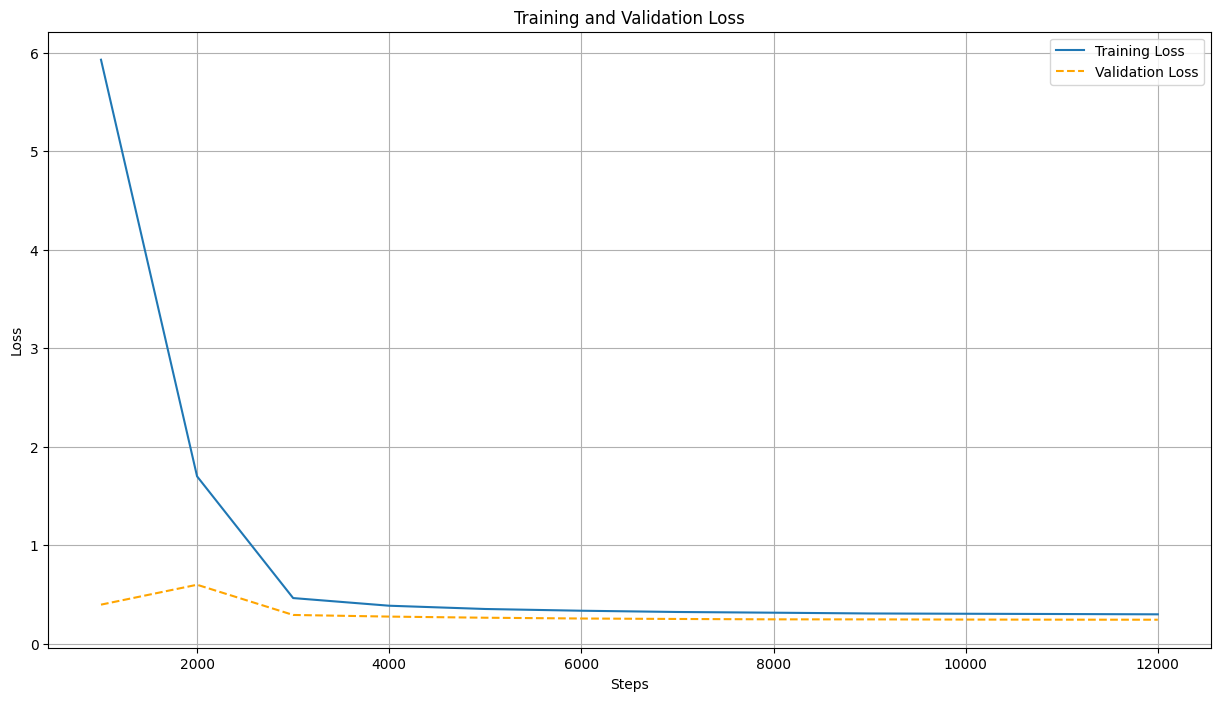

In [ ]:
logs = trainer.state.log_history
train_steps = [x['step'] for x in logs if 'loss' in x][1:]
train_loss = [x['loss'] for x in logs if 'loss' in x][1:]
eval_steps = [x['step'] for x in logs if 'eval_loss' in x]
eval_loss = [x['eval_loss'] for x in logs if 'eval_loss' in x]

plt.figure(figsize=(15, 8))
plt.plot(train_steps, train_loss, label='Training Loss')
plt.plot(eval_steps, eval_loss, label='Validation Loss', linestyle='--', color='orange')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_bleu(model, dataset, tokenizer):
    reference_texts = []
    translated_texts = []

    for data in dataset:
        data = {key: val.to(device) for key, val in data.items()}
        reference_text = tokenizer.decode(data["labels"], skip_special_tokens=True)
        reference_texts.append(reference_text)
        model.eval()
        with torch.no_grad():
            output = model.generate(data["input_ids"].unsqueeze(0), attention_mask=data["attention_mask"].unsqueeze(0))
        translated_texts.append(tokenizer.decode(output[0], skip_special_tokens=True))

    bleu_score = sacrebleu.corpus_bleu(translated_texts, [reference_texts])
    return bleu_score.score

bleu = compute_bleu(model, val_dataset, tokenizer)

/l/users/ahmed.aboeitta/espnet/tools/anaconda/envs/espnet/lib/python3.8/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
print(f"Bleu Score: {bleu:.2f}")

Bleu Score: 6.66


#### **Inference**

In [ ]:
def translate_arabic_to_english(model, tokenizer, arabic_sentence):
    model = model.to(device).eval()
    input_text = "translate Arabic to English: " + arabic_sentence
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=MAX_LENGTH, truncation=True).to(device)
    outputs = model.generate(inputs, max_length=MAX_LENGTH, num_beams=4, early_stopping=True)
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return translated_text

arabic_test_sentence = "مرحبا بكم في المكتبة"
translated_sentence = translate_arabic_to_english(model, tokenizer, arabic_test_sentence)
print(translated_sentence)

## ***Analysis:***


Marian NMT seems to be the best suited for this translation task, given its consistently decreasing losses and high BLEU score. MBART, despite its potential, might require more careful fine-tuning or hyperparameter adjustments to achieve optimal results. MT5's performance suggests that not all models, regardless of their size or complexity, are equally suited for all tasks; the initial state of the model and its pretraining tasks play crucial roles in its fine-tuning performance.

The core advantage Marian NMT holds over the other two models in terms of architecture is its specialization. Every aspect of Marian, from its attention mechanisms to its tokenization strategy, has been refined and optimized exclusively for machine translation.

## **Why MARIAN Model is the Best:**

* **MARIAN:**
  * Marian NMT is specifically tailored for neural machine translation tasks. Its architecture, hyperparameters, and even the attention mechanisms are optimized for translation.
  
  * The attention mechanisms in Marian NMT, such as self-attention, are fine-tuned to better understand the nuances of source and target languages in translation tasks. This focused design enables the model to achieve more accurate and coherent translations.
  
  * The training and validation losses for Marian NMT tend to decrease over time indicating that the model is learning and generalizing well. The BLEU score is the highest among the three models, suggesting very good translation quality.

* **MBART:**
  * While MBART is also a sequence-to-sequence model like Marian, its design is more generalized. MBART is built to handle a variety of tasks, from translation to text summarization.

  * MBART's unique pretraining approach involves reconstructing sentences with noise added. While this is useful for understanding context and generating coherent sequences, it might not always be as directly beneficial for translation as the specialized pretraining data Marian might use.  
  
  * MBART's training loss shows more fluctuations compared to Marian NMT, suggesting a less smooth learning process and possible overfitting scenarios or learning rate issues.

* **MT5:**
  * MT5, derived from the T5 framework, is designed for various text-to-text transfer tasks. While this design offers flexibility, it may not be specialized enough for nuanced machine translation tasks.

  * MT5 uses a unified SentencePiece tokenizer which, while powerful and capable of handling multiple languages, might not capture the intricacies of specific language pairs as effectively as a specialized system.
  
  * MT5 starts with an alarmingly high training loss, which drastically drops later. This suggests that the model's pre-trained weights were initially not very conducive for the task at hand, but they adjusted considerably with more training.

  * The massive gap in the training loss and the final BLEU score suggests that while MT5 is capable of adapting its weights for the task, its architecture or pretraining might not be as suited for this particular translation task.